In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from chart_studio.plotly import plot, iplot
import cufflinks as cf
cf.go_offline(connected=True)

In [2]:
return_df = pd.read_csv('../data/kospi/preprocessed/df_return.csv',index_col=0)
jaccard_df = pd.read_csv('../data/similarity/jaccard_df.csv',index_col=0)
cosine_df = pd.read_csv('../data/similarity/cosine_df.csv',index_col=0)

lv2_jaccard = jaccard_df.copy().loc[return_df.index] #거래일에 맞춰서 인덱싱
lv2_cosine = cosine_df.copy().loc[return_df.index]

## Main table II 구성

Excess return, 3-factor alpha, 5-factor alpha 을 계산한 table II 를 만들고자 합니다.
유사도 기준으로 Q1~Q5까지 낮은순부터 높은 순대로 portfolio를 만들고 document가 filing된 시점부터 종목을 보유하여 3개월 동안의 수익률을 보겠습니다. 그룹을 sorting하는 데 있어서는 전체유사도 평균이 아닌 개별기업의 연속된 사업보고서 값을 선정하였습니다.

Quantile 1(Q1) refers to firms that have the least similarity between their document this year and
the one last year; hence this portfolio consists of the “big changers.” Quintile 5 (Q5) refers
to firms that have the most similarity in their documents across years, and hence this
portfolio represents the “little to no changers.

In [4]:
lv2_jaccard[lv2_jaccard.loc[:,'삼양홀딩스'] > 0]

,삼양홀딩스,유한양행,CJ대한통운,두산,대림산업,한국테크놀로지그룹,기아차,동아쏘시오홀딩스,SK하이닉스,영풍,...,현대백화점,한국금융지주,GS,하나금융지주,아모레퍼시픽,LF,후성,SK이노베이션,CJ제일제당,KB금융
20110331,0.482558,NaN,0.615385,0.579749,0.630503,0.203113,0.705706,NaN,0.596091,0.576200,...,0.873362,NaN,NaN,0.462889,0.577154,NaN,0.633452,0.574394,0.755193,0.716630
20120330,0.349498,0.691877,0.500778,0.484272,0.604478,0.650970,0.404380,0.446479,0.344828,0.372517,...,NaN,NaN,0.692913,0.649770,0.555950,0.895184,0.592593,0.425806,0.579278,0.710660
20130401,0.541254,NaN,NaN,NaN,0.714286,0.597826,0.536538,0.645907,NaN,0.525890,...,0.725910,NaN,NaN,0.643997,0.551537,NaN,0.533141,0.571237,0.730924,NaN
20140331,0.623506,0.576659,0.528402,0.468793,0.643312,0.898990,0.697959,0.668571,0.452794,0.510526,...,0.763092,0.471028,0.881773,0.776367,0.604414,0.650526,0.604839,0.543253,0.754881,0.737799
20150331,0.688259,0.782927,0.616085,0.589710,0.665848,0.924460,0.677355,0.529118,0.324324,0.812367,...,0.640756,0.772939,0.130774,0.678119,0.518400,0.923913,0.818681,0.672179,0.678571,0.724490
20160330,0.632207,0.574423,0.579921,0.591931,0.571914,0.933852,0.791111,0.674319,0.317259,0.782341,...,0.726695,0.566667,0.724882,0.677509,0.487842,0.785276,0.794721,0.652893,0.599624,0.781513
20170331,0.643299,0.816705,0.541444,0.597531,0.629448,0.604712,0.692469,0.867362,0.585882,0.680357,...,0.729977,0.629002,0.743371,0.703704,0.556535,NaN,0.890244,0.864389,0.637708,0.701692
20180402,0.540034,0.715789,0.599490,NaN,NaN,0.739583,0.646035,0.815789,0.321534,0.839187,...,0.652427,0.507442,0.578341,0.780149,0.638095,NaN,0.828804,0.739049,NaN,0.753463
20190401,0.690635,0.532609,0.727488,NaN,0.510638,0.625402,0.678700,0.738854,NaN,0.811252,...,0.758364,0.564672,0.671296,0.776720,0.543662,0.870103,0.857909,0.810392,0.677365,0.821839


In [15]:
return_df.head(10)

,삼양홀딩스,유한양행,CJ대한통운,두산,대림산업,한국테크놀로지그룹,기아차,동아쏘시오홀딩스,SK하이닉스,영풍,...,현대백화점,한국금융지주,GS,하나금융지주,아모레퍼시픽,LF,후성,SK이노베이션,CJ제일제당,KB금융
20100104,0.004492,-0.011229,-0.038801,-0.026209,0.025240,-0.017581,0.037406,0.038918,0.041037,0.000000,...,0.004444,0.022388,-0.001479,0.013678,0.008563,0.011094,-0.006665,-0.004255,0.007299,-0.005025
20100105,-0.005589,0.005682,-0.001835,-0.002156,-0.009379,-0.043934,-0.055288,-0.033714,-0.031120,-0.033392,...,-0.044248,0.010219,0.004444,0.016492,-0.028655,-0.039185,-0.006441,0.038462,0.062802,-0.011785
20100106,-0.007847,0.011292,0.036765,0.055020,0.020118,-0.006239,0.010178,-0.027126,0.051392,-0.023636,...,-0.023148,-0.008671,0.010324,0.000000,-0.060115,-0.008157,0.014317,0.004115,0.002273,-0.003407
20100107,-0.015841,-0.008383,0.003546,0.027614,-0.002320,-0.025284,-0.045340,0.007970,-0.006110,-0.003724,...,0.004739,-0.020408,0.010219,-0.013274,-0.022087,-0.008224,0.007989,-0.004098,-0.011338,-0.011966
20100108,-0.002303,-0.008440,0.017668,0.064674,0.010465,0.008705,0.021108,-0.007907,0.010246,-0.003738,...,-0.023585,0.066964,-0.004335,0.002990,-0.015466,0.009950,0.005020,0.008230,0.000000,0.001730
20100111,0.002308,-0.017052,0.031250,-0.014021,0.034522,-0.010701,-0.031008,-0.031878,-0.026369,-0.005629,...,0.000000,-0.006974,0.010160,0.067064,0.030198,-0.019704,0.042587,0.008163,-0.009174,0.020725
20100112,-0.002303,-0.020234,-0.016835,0.047401,0.044494,-0.002181,0.010667,0.000000,0.002083,-0.003774,...,0.019324,-0.011236,-0.020115,-0.001397,-0.014064,0.005025,-0.011094,0.000000,0.009259,-0.005076
20100113,-0.012671,-0.011799,-0.029110,-0.022628,-0.007455,-0.041088,0.002639,-0.032917,0.000000,-0.013258,...,-0.028436,-0.029830,0.014663,-0.001399,-0.002377,-0.015000,0.009944,-0.044534,-0.032110,-0.018707
20100114,-0.008159,-0.005955,0.021164,-0.009261,0.011803,-0.004558,0.005263,-0.012768,0.058212,0.000000,...,0.004878,0.023426,0.027457,-0.002801,-0.004766,0.015228,-0.013633,0.008475,0.037915,-0.005199
20100115,0.001156,0.008990,-0.001727,0.056072,-0.007423,-0.002290,0.000000,-0.004311,0.025540,-0.003839,...,-0.004854,-0.024320,0.054852,-0.008427,-0.026352,0.030000,0.009982,-0.004202,0.022831,-0.001742


In [13]:
val_idx,val_col = np.where(np.isfinite(jaccard_df))
container = np.full(shape=len(val_idx),3-,fill_value=np.nan)

array([ 447,  448,  451, ..., 3377, 3377, 3380], dtype=int64)

In [5]:
def get_after_filing_return(df,windows=30) : #기업 columns와 rcp_index 토대로 누적수익률 (sim_type 상관없음)
    
    val_idx,val_col = np.where(np.isfinite(df)) 
    container = np.full(shape=(len(val_idx),windows),fill_value=np.nan)
    idx_ls = []
    for num,(idx,col) in enumerate(zip(val_idx,val_col)) : 
        tmp = return_df.iloc[idx:idx+windows,col].values
        if windows - len(tmp) > 0 : 
            tmp = np.array(tmp.tolist()+[np.nan]*(windows-len(tmp)))
        container[num] = tmp #한기업의 filing이후 window_size만큼의 수익률 저장
        
        tmp_idx = return_df.index[idx]
        tmp_col = return_df.columns[col]        
        idx_ls.append("{}_{}".format(tmp_col,tmp_idx))
    
    final_df = pd.DataFrame(data=container,index=idx_ls)    
    return final_df

In [6]:
get_after_filing_return(lv2_jaccard)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
LF_20110324,0.013986,-0.012069,-0.008726,0.028169,0.010274,0.003390,0.016892,0.001661,-0.018242,0.003378,...,0.018377,-0.001504,-0.031627,-0.004666,0.031250,0.006061,0.000000,0.037651,-0.021771,0.038576
S&T모티브_20110325,0.018272,0.003263,-0.014634,-0.013201,0.036789,-0.001613,-0.006462,-0.008130,-0.006557,-0.028053,...,-0.001460,0.029240,-0.061080,-0.036309,-0.031397,0.009724,-0.020867,-0.026230,-0.015152,-0.023932
LG디스플레이_20110328,0.001437,-0.021521,-0.013196,0.022288,0.030523,0.004231,0.033708,0.000000,0.005435,0.013514,...,0.011125,-0.026895,0.022613,-0.019656,-0.035088,0.027273,-0.003793,-0.021574,-0.005188,0.036506
고려제강_20110329,0.015237,0.000000,0.002450,-0.004965,-0.005028,0.012576,0.003734,0.004934,0.008612,0.023180,...,0.010711,0.010634,-0.041944,-0.020695,0.006179,-0.002464,0.009919,-0.006134,-0.023399,0.013880
유한양행_20110330,0.013336,-0.026322,0.000000,-0.003383,0.016957,0.003338,-0.003327,-0.009998,-0.013471,-0.020482,...,0.010645,-0.007027,0.014138,0.003498,-0.013892,0.014088,-0.024315,-0.024912,-0.029195,-0.003756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
후성_20190401,0.025469,0.005229,0.013004,-0.002567,0.003861,0.002564,0.011509,-0.002528,0.001267,0.010127,...,0.027097,0.007538,0.024938,0.017032,0.007177,-0.010689,-0.050420,-0.001264,-0.039241,-0.005270
SK이노베이션_20190401,0.011142,0.005510,0.008219,-0.002717,0.008174,0.002703,0.000000,-0.008086,0.008152,-0.002695,...,0.002681,-0.024064,0.002740,-0.016393,-0.016667,-0.005650,-0.039773,0.008876,-0.017595,-0.008955
CJ제일제당_20190401,0.004644,0.004622,0.000000,-0.003067,-0.007692,0.018605,0.001522,0.001520,-0.015175,0.006163,...,0.006339,-0.007874,-0.003175,-0.014331,0.008078,-0.004808,-0.014493,-0.019608,-0.005000,-0.033501
KB금융_20190401,0.051374,0.022727,0.005556,0.003315,-0.002203,-0.006623,-0.004444,0.008929,0.000000,0.005531,...,0.023128,-0.005382,0.010823,-0.002141,0.000000,0.004292,-0.014957,0.005423,-0.003236,-0.001082


In [16]:
def get_return_per_sim(df,window):
    
    sim_df = df.copy()
    df_ = get_after_filing_return(sim_df,windows=window)
    
    index_ls = []
    value_ls = []
    for i in sim_df.columns:
        for j in sim_df.index:
            if sim_df.loc[j,i] > 0:
                value_ls.append(sim_df.loc[j,i])
                index_ls.append(i + '_'+str(j))
            
    unit_df = pd.DataFrame([index_ls,value_ls] , index = ['title','similarity']).T
    unit_df = unit_df.sort_values(by = 'similarity', ascending =True).reset_index(drop = True)

    sorted_values = [] #idx별 유사도값
    for i in df_.index:
        for idx,j in enumerate(unit_df.title): 
            if i == j:
                sorted_values.append(unit_df['similarity'][idx])
    
    df_ = df_.cumsum(1).iloc[:,-1].reset_index()
    df_.columns = ['corp_rcp','cum_return']
    df_['sim'] = sorted_values
    df_ = df_.sort_values(by = 'sim',ascending=True).reset_index(drop=True)
    
    return df_


In [42]:
def returns_per_date(df,*argv):
    ls_ = [get_return_per_sim(df,arg) for arg in argv]
    q_values=[]
    quarter = 5 #5분위
    for x in ls_:
        a = len(x) // quarter #200
        q = [x.cum_return[i*a:(i+1)*a].mean() for i in range(quarter)]
        q.append(q[-1]-q[0]) #long Q5 ,short Q1
        q_values.append(q)
    
    df = pd.DataFrame([k for k in q_values],index = [f'{arg} days' for arg in argv],
                      columns = [f'Q{i+1}'for i in range(len(q_values[0]))])
    df = df.rename(columns = {'Q6':'Q5-Q1'})
    df = df*100
    
    return df
    

In [46]:
return_cosine

,Q1,Q2,Q3,Q4,Q5,Q5-Q1
20 days,1.217420,2.864055,1.408786,2.219245,3.375964,2.158544
40 days,-0.705429,1.012594,1.162300,2.297534,2.908659,3.614089
50 days,-1.479557,1.148197,0.843248,2.212963,2.737197,4.216753
60 days,-2.651172,0.756748,-0.016412,0.708067,1.280291,3.931463
100 days,-1.942013,-2.424806,-2.418503,-0.696150,0.237811,2.179825
120 days,1.172842,1.590011,0.131534,2.515889,2.156946,0.984104


In [43]:
return_jaccard = returns_per_date(lv2_jaccard,20,40,50,60,100,120)
return_cosine = returns_per_date(lv2_cosine,20,40,50,60,100,120)

Q1~Q5 을 net pooling similarity로 구성했을 때의 결과값이다. time-series effect와 cross-sectional effect가 모두 포함되어있기에 
극단적인 수치가 나온 결과..  잘나온것으로 보이지만.. calender time portpolio returns 는 이와 다르다.

In [44]:
return_jaccard

,Q1,Q2,Q3,Q4,Q5,Q5-Q1
20 days,0.955043,2.025042,2.932510,1.376949,3.760438,2.805395
40 days,-1.078367,0.808451,2.455538,1.189568,3.288017,4.366384
50 days,-2.096185,0.580430,2.629671,1.333369,2.998251,5.094436
60 days,-2.587654,-0.737557,1.657036,0.346921,1.345514,3.933168
100 days,-2.678137,-3.405412,-0.608029,-0.615576,0.079679,2.757816
120 days,0.560617,1.051665,2.018300,1.388277,2.605793,2.045176


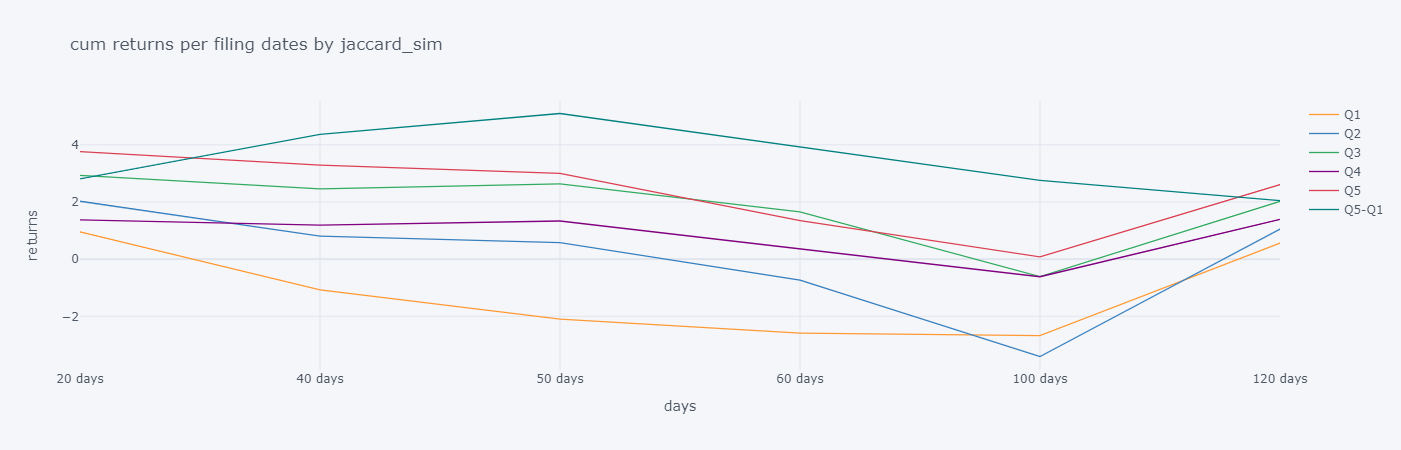

In [47]:
return_jaccard.iplot(kind='line',title = 'cum returns per filing dates by jaccard_sim ',xTitle = 'days',yTitle='returns')

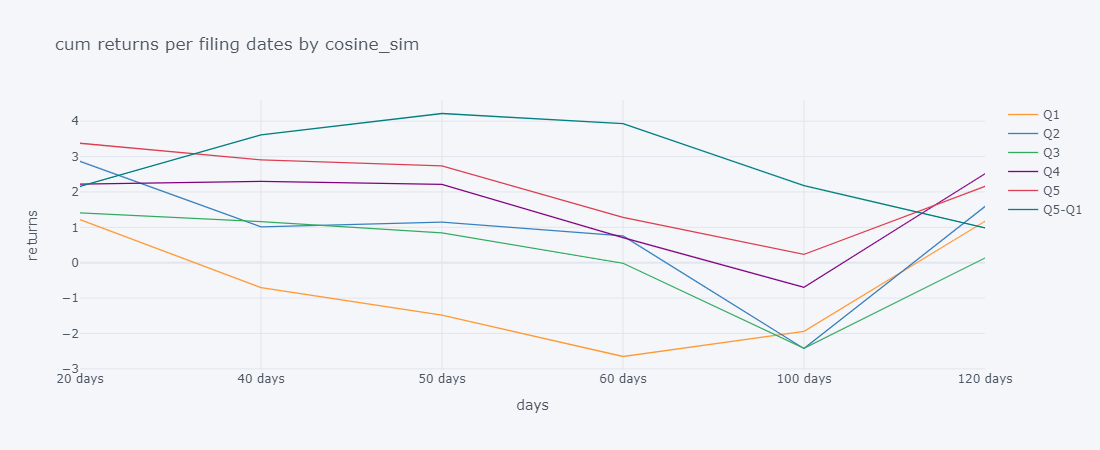

In [49]:
return_cosine.iplot(kind='line',title = 'cum returns per filing dates by cosine_sim',xTitle = 'days',yTitle='returns')

In [50]:
return_jaccard_after = returns_per_date(lv2_jaccard,120,140,160,180,200)
return_cosine_after = returns_per_date(lv2_cosine,120,140,160,180,200)

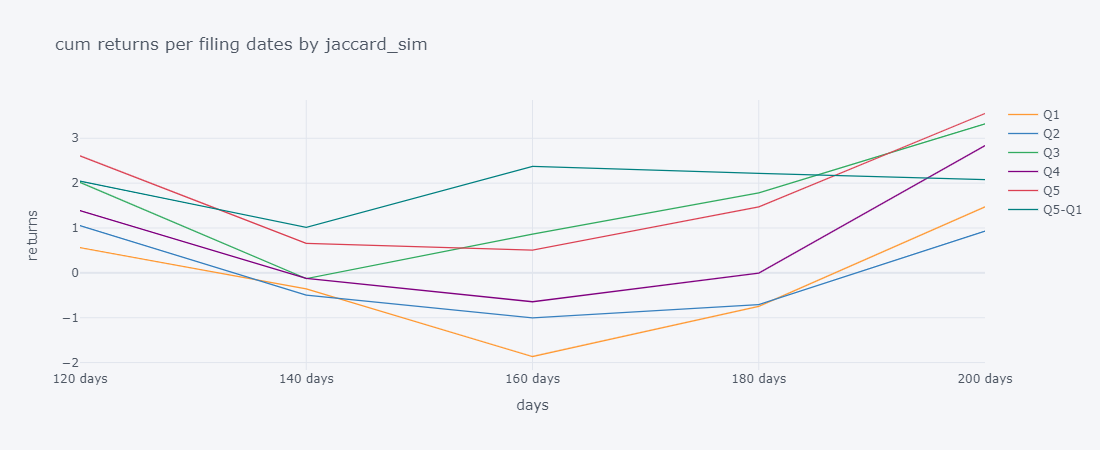

In [51]:
return_jaccard_after.iplot(kind='line',title = 'cum returns per filing dates by jaccard_sim',xTitle = 'days',yTitle='returns')

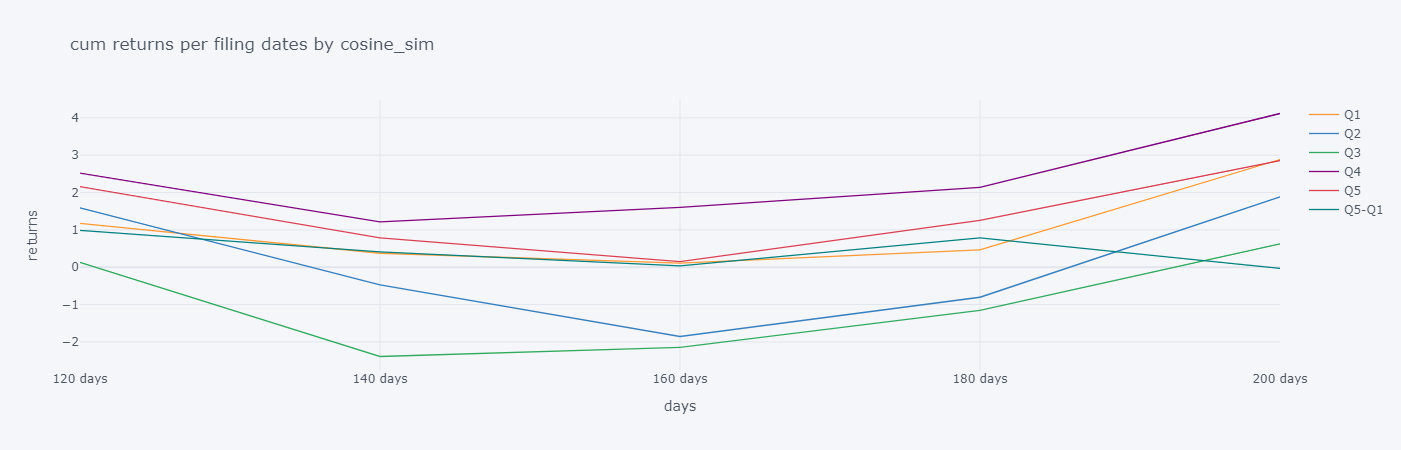

In [52]:
return_cosine_after.iplot(kind='line',title = 'cum returns per filing dates by cosine_sim',xTitle = 'days',yTitle='returns')